In [3]:
import pandas as pd
import numpy as np
import os
import sys
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix, classification_report, roc_curve
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
import pickle

In [4]:
class ClassificationPipeline(BaseEstimator, TransformerMixin):
    def __init__(self, encoder, model, decoder=None):
        self.encoder = encoder
        self.model = model
        self.decoder = decoder
    def fit(self, X, y):
        X_encoded = self.encoder.fit_transform(X)
        self.model.fit(X_encoded, y)
        return self
    def predict(self, X):
        X_encoded = self.encoder.transform(X)
        y_pred = self.model.predict(X_encoded)
        return self.decoder(y_pred) if self.decoder else y_pred
    def predict_proba(self, X):
        X_encoded = self.encoder.transform(X)
        return self.model.predict_proba(X_encoded)

##**Business Understanding**

The objective is to detect fraudulant credit card transactions using classification models. Creating a model with high recall and high precision will reduce financial loss and avoid false alerts of fradulant activity.

##**Data Acquisition**

This dataset, Credit Card Fraud Detection, comes from Kaggle as a CSV file.

In [5]:
url = "https://raw.githubusercontent.com/nsethi31/Kaggle-Data-Credit-Card-Fraud-Detection/master/creditcard.csv"
df = pd.read_csv(url)
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


##**Data Cleaning & Preprocessing**

In [7]:
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [8]:
print(df.info())
# imbalanced class distribution
print(df['Class'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [9]:
# amount and time are not PCA transformed like other features
df['scaled_amount'] = StandardScaler().fit_transform(df[['Amount']])
df['scaled_time'] = StandardScaler().fit_transform(df[['Time']])

# drop unscaled time and amount
df.drop(['Time', 'Amount'], axis=1, inplace=True)

# features (X) is all columns except target column
X = df.drop('Class', axis=1)
# target column (y)
y = df['Class']

##**Exploratory Data Analysis & Statistical Analysis**

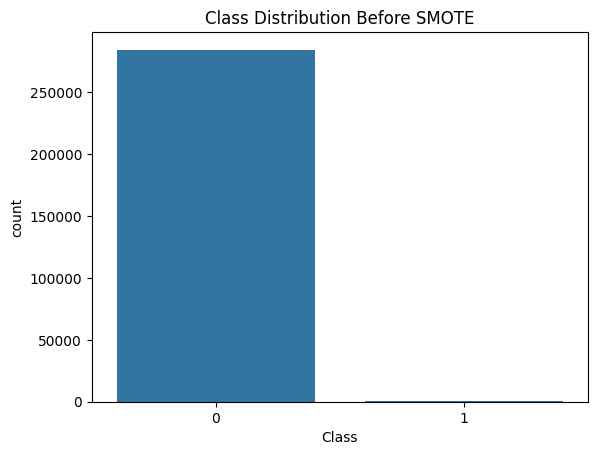

In [10]:
# visualize class imbalance
sns.countplot(x=y)
plt.title("Class Distribution Before SMOTE")
plt.show()

##**Feature Engineering**

All features except Time and Amount were PCA transformed prior to being added to the dataset. The only necessary feature engineering was to use a Standard Scaler to scale the Time and Amount features. All other features were already scaled and ready to use for the models.

In [11]:
# created scaled amount and time features
# dropped unscaled features

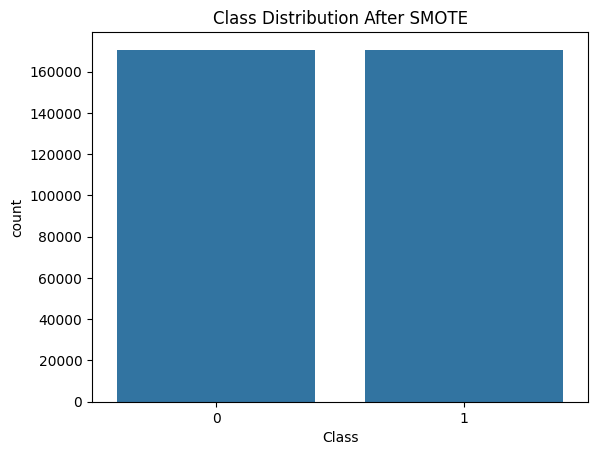

In [12]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

# handle class imbalance with SMOTE
smote = SMOTE(random_state=42)
X_train_resample, y_train_resample = smote.fit_resample(X_train, y_train)

# visualize class distribution after handling class imbalance using SMOTE
sns.countplot(x=y_train_resample)
plt.title("Class Distribution After SMOTE")
plt.show()

##**Model Training**

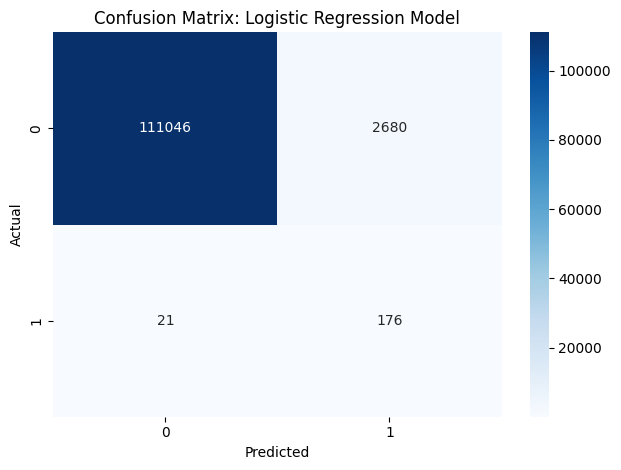

In [15]:
# LOGISTIC REGRESSION MODEL
lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
lr.fit(X_train_resample, y_train_resample)

# make predictions on test set
y_pred = lr.predict(X_test)
y_prob = lr.predict_proba(X_test)[:, 1]

# VISUALIZATIONS
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Logistic Regression Model")
plt.tight_layout()
plt.savefig("conf_matrix_lr.png")
plt.show()

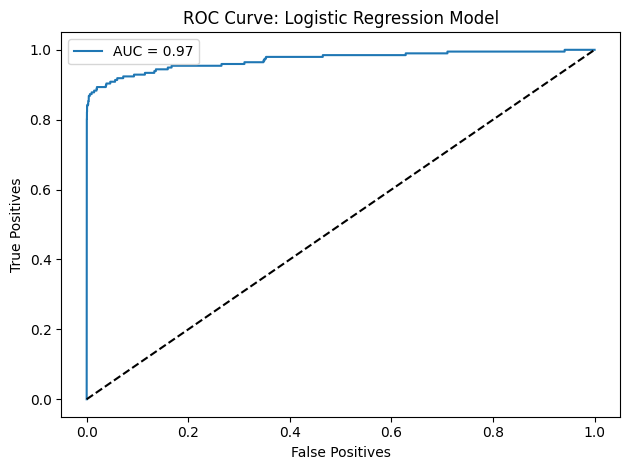

In [16]:
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positives")
plt.ylabel("True Positives")
plt.title("ROC Curve: Logistic Regression Model")
plt.legend()
plt.tight_layout()
plt.savefig("roc_curve_lr.png")
plt.show()

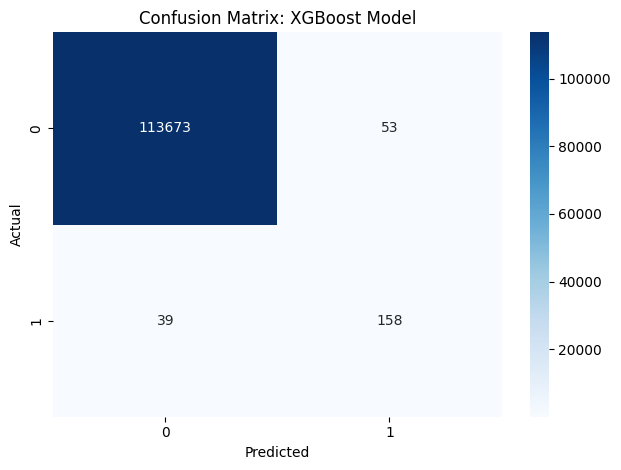

In [17]:
# XGBOOST MODEL
xgb = XGBClassifier(eval_metric='logloss', random_state=42)
xgb.fit(X_train_resample, y_train_resample)

# predict on test set
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

# VISUALIZATIONS
cm_xgb = confusion_matrix(y_test, y_pred_xgb)
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: XGBoost Model")
plt.tight_layout()
plt.savefig("conf_matrix_xgb.png")
plt.show()

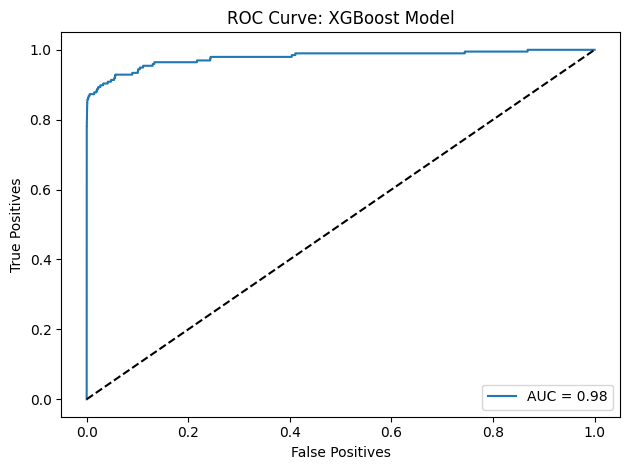

In [19]:
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
plt.plot(fpr_xgb, tpr_xgb, label=f"AUC = {roc_auc_score(y_test, y_prob_xgb):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positives")
plt.ylabel("True Positives")
plt.title("ROC Curve: XGBoost Model")
plt.legend()
plt.tight_layout()
plt.savefig("roc_curve_xgb.png")
plt.show()

##**Model Evaluation & Explainability**

In [20]:
print("Classification Report (Logistic Regression Model):\n", classification_report(y_test, y_pred))

Classification Report (Logistic Regression Model):
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    113726
           1       0.06      0.89      0.12       197

    accuracy                           0.98    113923
   macro avg       0.53      0.93      0.55    113923
weighted avg       1.00      0.98      0.99    113923



In [21]:
print("XGBoost Classification Report:\n", classification_report(y_test, y_pred_xgb))

XGBoost Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00    113726
           1       0.75      0.80      0.77       197

    accuracy                           1.00    113923
   macro avg       0.87      0.90      0.89    113923
weighted avg       1.00      1.00      1.00    113923



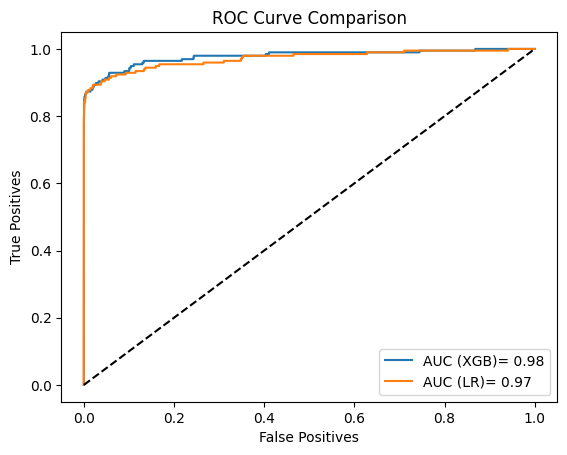

In [22]:
# generate ROC curve for both models
plt.plot(fpr_xgb, tpr_xgb, label=f"AUC (XGB)= {roc_auc_score(y_test, y_prob_xgb):.2f}")
plt.plot(fpr, tpr, label=f"AUC (LR)= {roc_auc_score(y_test, y_prob):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positives")
plt.ylabel("True Positives")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()

##**Monitoring & Maintenance**

The logistic regression and XGBoost models, including key performance metrics and visualizations, were logged using MLflow to track model performance across experiment runs. The end-to-end project was also wrapped in a pipeline structure and saved as a pickle file in MLflow. This part of the project was removed to streamline the workflow and focus on direct model evaluation. Pipeline storage was not essential for the final deployment of the project.